## Projeto Churn 
Desenvolvendo um Modelo de Machine
Learning Capaz de Prever se um Cliente irá Cancelar seu
Contrato com a operadora 

Área de Aplicação: retenção de clientes e melhoria da satisfação do cliente;

Justificativa: reduzir o churn pode aumentar a receita e reduzir custos associados à aquisição de novos clientes.

In [ ]:
#### Importar as bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
# Classifier modules
#MODEL
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier

from ydata_profiling import ProfileReport

In [ ]:
##### Carregar os dados
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

In [79]:
# Verificar o cabeçalho
train.head()

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4030,Female,0,No,No,56.0,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,Two year,No,NaN,45.05,2560.1,0
1,6731,Male,0,Yes,Yes,NaN,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65,0
2,6479,Female,0,Yes,No,60.0,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.7,0
3,6861,Female,0,No,No,37.0,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1
4,3266,Male,0,Yes,Yes,29.0,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.8,1


In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                5634 non-null   int64  
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   int64  
 3   Partner           5634 non-null   object 
 4   Dependents        5416 non-null   object 
 5   tenure            5173 non-null   float64
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   object 


In [ ]:
test.info()

In [ ]:
# o ydata produz uma analise avançada EAD, podemos usa-lo
# de forma eficaz e identificar oportunidades e insights de forma rapida com
# recursos de estatistica descritiva 

In [85]:
# criamos o profile chamando o objeto passando o dataset
# e chamamos para o frame do notebook

profile = ProfileReport(test,title='Churn 2020')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
train.isnull().sum()
# Verificado que temos observações nulas no dataframe

In [ ]:
test.isnull().sum()
# Verificado que temos observações nulas no dataframe

In [ ]:
train.duplicated()


In [ ]:
# removendo colunas não necessárias para a analise

In [ ]:
treino = train.copy()
teste = test.copy()
treino=treino.drop(columns=['id'])
teste = teste.drop(columns=['id'])

In [ ]:
# listar colunas por tipo 
list(treino.select_dtypes('object').columns),
list(teste.select_dtypes(['int','float']).columns)

In [ ]:
list(treino.select_dtypes(['float','int']).columns)

In [ ]:
# Verificado que TotalCharges é um campo numerico e esta como string
# precisamos converter para numerico 
#treino['TotalCharges'] 
#teste = pd.to_numeric(treino['TotalCharges'].str.replace(' ','.'),errors='coerse')

# Para capturar as string vazia e remove-las faremos dois passos , separar as string

passo1= [len(i.split()) for i in treino['TotalCharges']]

# # guardar o indice de  'Total_Charges' onde o final não é igual a 1.
passo2=[i for i in range(len(passo1)) if passo1[i] != 1]

print('Numero de observações com entradas vazias nas string:', len(passo2))


In [81]:
# o numero de string vazias comparado com o banco de dados é muito pequeno e optamos 
# por deletar as observações onde estão vazias
# observe que excluimos apenas a linha no axis=0 onde estão as linhas
# resetamos o indice para realinhar 
treino = treino.drop(passo2, axis = 0).reset_index(drop=True)
passos= passo2
print('Numero de entradas vazias nas string:', len(passo2))
# não temos nulos em teste


Numero de entradas vazias nas string: 8


In [ ]:
#mesmos passos para teste

pas1= [len(i.split()) for i in teste['TotalCharges']]

# # guardar o indice de  'Total_Charges' onde o final não é igual a 1.
pas2=[i for i in range(len(pas1)) if pas1[i] != 1]

print('Numero de entradas vazias nas string:', len(pas2))
# tentando converter , apareceu erro de tipo, provavelmente esta coluna string vazias


In [ ]:
#atualizando o banco de testes
teste = teste.drop(pas2, axis = 0).reset_index(drop=True)
print('Numero de entradas vazias nas string:', len(pas2))
# não temos nulos em teste

In [ ]:
# por fim vamos converter para Numero a COluna  TotalCharges
treino['TotalCharges'] = treino['TotalCharges'].astype(float)
treino['TotalCharges'].dtypes
teste['TotalCharges']= teste['TotalCharges'].astype(float)
teste['TotalCharges'].dtypes

In [ ]:
#temos nulos em tenures 
treino['tenure'].isnull().sum()

#vamos converter 

treino['tenure'] = treino['tenure'].fillna(treino['tenure'].mean())
treino['tenure'].isnull().sum()

In [ ]:
#temos nulos em tenures 
teste['tenure'].isnull().sum()

#vamos converter 

teste['tenure'] = treino['tenure'].fillna(treino['tenure'].mean())
teste['tenure'].isnull().sum()

In [ ]:
#converter coluna de string para float com pandas
treino['MonthlyCharges'] = pd.to_numeric(treino['MonthlyCharges'])
treino['tenure'] = pd.to_numeric(treino['tenure'])
treino['TotalCharges'] = pd.to_numeric(treino['TotalCharges'])


In [ ]:
treino['Dependents'].value_counts()

In [ ]:
treino['Dependents'].isnull().sum()

In [ ]:
#preechendo os valores nulos com A maior frequencia de dados no caso Yes
treino['Dependents'] = treino['Dependents'].ffill()

In [ ]:
treino['Dependents'].isnull().sum()

In [ ]:
# verificando valores em treino['Payment Method']
treino['PaymentMethod'].value_counts()

In [ ]:
treino['PaymentMethod'].describe()

In [ ]:
# o valor mais frequente é o metodo Electronic check, será o que vamos utilizar
treino['PaymentMethod'] = treino['PaymentMethod'].fillna('Electronic check')
teste['PaymentMethod'] =  teste['PaymentMethod'].fillna('Electronic check')

treino['PaymentMethod'].isnull().sum(), teste['PaymentMethod'].isnull().sum()

In [ ]:
cat = list(treino.select_dtypes('object').columns)
cat_teste = list(teste.select_dtypes('object').columns)
num = list(treino.select_dtypes(['int64','float64']).columns)
num=num[:-1]
num_teste = list(teste.select_dtypes(['int64','float64']).columns)
print('categorias treino-->\n',cat,'\ncategorias teste->\n',cat_teste)
print('*'*100)

print('numericas treino-->\n',num,'\n numericas teste->\n',num_teste)

In [ ]:
# Transformar a escala da colunas numericas para normalizar 
# Recursos da escala
Standard_Scaler = StandardScaler()
Standard_Scaler.fit_transform(treino[num])
Standard_Scaler.transform(teste[num_teste])

In [ ]:
## agora vamos aplicar o one hot encoding para formatar nossas categorias para a linguagem 
# Dos algoritmos zero e um

In [ ]:
# Vamos codificar varias colunas. Infelismente voce não podera passar uma lista para o 
# objeto,então voce tera que copiar e colar todas as colunas para o metodo do OneHot

transformador = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'),
     ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
      'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
      'TechSupport', 'StreamingTV','StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']))

In [ ]:
# Vamos encodar a tabela de testes primeiro
transformado = transformador.fit_transform(treino)

In [ ]:
transformado_df = pd.DataFrame(transformado,columns=transformador.get_feature_names_out())

#One Hot removeu o indice , vamos voltar com eles
transformado_df.index = treino.index

In [ ]:
# vamos juntar as tabelas 
treino = pd.concat([treino,transformado_df],axis=1)

#vamos apagar as velhas categorias que foram codificadas
treino.drop(columns=cat,axis=1,inplace = True)

# vamos ver a tabela codificada
treino.head()

In [ ]:
# vamos fazer a mesma coisa para os testes

# Vamos encodar a tabela de testes primeiro
transformado = transformador.transform(teste)

In [ ]:
#transformatando de volta
transformado_df = pd.DataFrame(transformado,columns=transformador.get_feature_names_out())

#One Hot removeu o indice , vamos voltar com eles
transformado_df.index = teste.index

In [ ]:
# vamos juntar as tabelas 
#teste = pd.concat([teste,transformado_df],axis=1)

#vamos apagar as velhas categorias que foram codificadas
cat_teste
#teste.drop(cat_teste,axis=1,inplace = True)

# vamos ver a tabela codificada
teste.head()

In [ ]:
treino['tenure']  = treino['tenure'].astype(int)
teste['tenure'] =teste['tenure'].astype(int)


In [ ]:
print(treino.columns)

In [ ]:
treino.columns =['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'gender_Female', 'gender_Male',
       'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes',
       'PhoneService_No', 'PhoneService_Yes',
       'MultipleLines_No',
       'MultipleLines_No phone service',
       'MultipleLines_Yes',
       'InternetService_DSL',
       'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
        'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service',
       'StreamingTV_Yes', 'StreamingMovies_No',
       'StreamingMovies_No internet service',
       'StreamingMovies_Yes',
       'contract_Month-to-month',
       'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_No',
       'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check',
       'PaymentMethod_Mailed check']

In [ ]:
treino

In [ ]:
alvo= treino['Churn']
test2= treino[:]

### Verificar o melhor modelo
####  1° RandomForestClassifier 10 fold - cross validation

In [ ]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

clf = RandomForestClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=3, n_estimators=5000, random_state=13)
clf = clf.fit(treino,alvo)
scoring = 'accuracy'
score = cross_val_score(clf,treino,alvo ,cv=k_fold,n_jobs=1,scoring=scoring)

# o resultado da avaliação cruzado será : o resultado clf, do banco de treino, target o objetivo
#print(score)
mean_score_rfc= score.mean()
print(f'#### Score médio do Randon FOrest: {mean_score_rfc * 100:.2f}%  ')

#fimp = pd.Series(data=clf.feature_importances_, index=treino.columns).sort_values(ascending=False)
#plt.figure(figsize=(17,13))
#plt.title("Feature importance")
#ax = sns.barplot(y=fimp.index, x=fimp.values, palette='inferno', orient='h')

#### 2° KNeareast Neighbor  10 fold - cross validation

In [ ]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

clf= KNeighborsClassifier()
scoring = 'accuracy'
score = cross_val_score(clf,treino,alvo ,cv=k_fold,n_jobs=1,scoring=scoring)
# o resultado da avaliação cruzado será : o resultado clf, do banco de treino, target o objetivo
print(score)
mean_score_kn = score.mean()
print(f'#### Score médio do kNeighbors Classifier: {mean_score_kn * 100:.2f}%  ')

#### 3° Decision Tree 10 fold - cross validation

In [ ]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

clf= DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf,treino,alvo ,cv=k_fold,n_jobs=1,scoring=scoring)
# o resultado da avaliação cruzado será : o resultado clf, do banco de treino, target o objetivo
print(score)
mean_score_dt = score.mean()
print(f'#### Score médio do DECISION TREE: {mean_score_dt * 100:.2f}%  ')

#### 4° Decision Tree 10 fold - cross validation

In [ ]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

clf= SVC()
scoring = 'accuracy'
score = cross_val_score(clf,treino,alvo ,cv=k_fold,n_jobs=1,scoring=scoring)
# o resultado da avaliação cruzado será : o resultado clf, do banco de treino, target o objetivo
print(score)
mean_score_svc= score.mean()
print(f'#### Score médio do Suport Vector Machine: {mean_score_svc * 100:.2f}%  ')

### Verificar o melhor modelo
####  5° Naive Bayes 10 fold - cross validation

In [ ]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

clf= GaussianNB()
scoring = 'accuracy'
score = cross_val_score(clf,treino,alvo ,cv=k_fold,n_jobs=1,scoring=scoring)
# o resultado da avaliação cruzado será : o resultado clf, do banco de treino, target o objetivo
print(score)
mean_score_nb= score.mean()
print(f'#### Score médio do Naive Bayes: {mean_score_nb * 100:.2f}%  ')

#### Resultado para avaliação do melhor modelo a ser implementado

In [ ]:
mean_model =[(mean_score_nb*100),(mean_score_kn*100),(mean_score_svc*100),(mean_score_dt*100)]
model_arr=['NB','KNN','DT','SVC']
nameCol= pd.DataFrame(model_arr,columns=['Model'])
results = pd.DataFrame(mean_model,columns=['Results'])

modeling= pd.concat([nameCol,results],axis=1)
modeling= pd.DataFrame(modeling)
modeling

In [ ]:
# aqui esta o resultado da performance dos modelos

<Axes: xlabel='Model'>

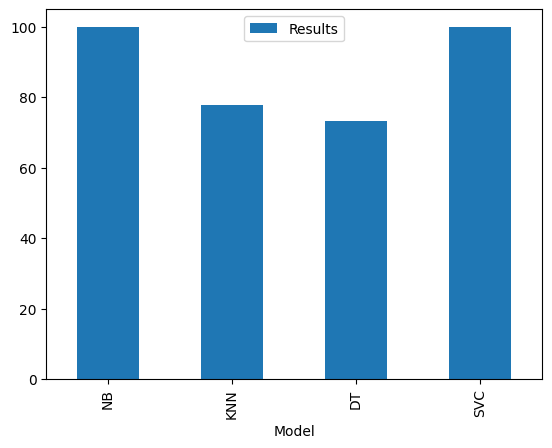

In [78]:
modeling.plot(kind='bar',x='Model',y='Results')